In [1]:
import hashlib

from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_classic.tools.retriever import create_retriever_tool
from langchain_classic import hub
from langchain.agents import create_agent
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})
llm_eval = ChatOpenAI(model='gpt-5-nano', temperature=0)
llm_gen = ChatOpenAI(model='gpt-5-mini', temperature=0)

In [3]:
def create_pdf_retriever(
        pdf_path: str,
        persist_directory: str,
        embedding_model,
) -> Chroma.as_retriever:
    loader = PyMuPDFLoader(pdf_path)
    docs = loader.load()
    full_text = '\n\n'.join(doc.page_content for doc in docs)
    text_splitter = SemanticChunker(embeddings=embedding_model)
    docs = text_splitter.create_documents([full_text])

    ids = []
    for doc in docs:
        doc.metadata['source'] = pdf_path
        doc_hash = hashlib.sha256(doc.page_content.encode('utf-8')).hexdigest()
        ids.append(doc_hash)

    vectorstore = Chroma.from_documents(persist_directory=persist_directory, documents=docs, embedding=embedding_model, ids=ids)

    return vectorstore.as_retriever()

In [4]:
japan_path = './data/ict_japan_2024.pdf'
usa_path = './data/ict_usa_2024.pdf'
japan_db_path = './data/db_ict_policy_japan_2024_2'
usa_db_path = './data/db_ict_policy_usa_2024_2'

In [5]:
retreiver_japan = create_pdf_retriever(
    pdf_path=japan_path,
    persist_directory=japan_db_path,
    embedding_model=embeddings
)

retriever_usa = create_pdf_retriever(
    pdf_path=usa_path,
    persist_directory=usa_db_path,
    embedding_model=embeddings
)

In [6]:
jp_engine = create_retriever_tool(
    retriever=retreiver_japan,
    name='japan_ict',
    description='일본의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

us_engine = create_retriever_tool(
    retriever=retriever_usa,
    name='usa_ict',
    description='미국의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

tools = [jp_engine, us_engine]

In [7]:
prompt_react = hub.pull('hwchase17/react')
print(prompt_react.template)
print('--prompt end--')

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
--prompt end--


In [8]:
template = '''다음 질문에 최선을 다해 답변하세요. 당신은 다음 도구들에 접근할 수 있습니다:

{tools}

다음 형식을 사용하세요:

Question: 답변해야 하는 입력 질문
Thought: 무엇을 할지 항상 생각하세요
Action: 취해야 할 행동, [{tool_names}] 중 하나여야 합니다. 리스트에 있는 도구 중 1개를 택하십시오.
Action Input: 행동에 대한 입력값
Observation: 행동의 결과
... (이 Thought/Action/Action Input/Observation의 과정이 N번 반복될 수 있습니다)
Thought: 이제 최종 답변을 알겠습니다
Final Answer: 원래 입력된 질문에 대한 최종 답변

## 추가적인 주의사항
- 반드시 [Thought -> Action -> Action Input format] 이 사이클의 순서를 준수하십시오. 항상 Action 전에는 Thought가 먼저 나와야 합니다.
- 최종 답변에는 최대한 많은 내용을 포함하십시오.
- 한 번의 검색으로 해결되지 않을 것 같다면 문제를 분할하여 푸는 것은 중요합니다.
- 정보가 취합되었다면 불필요하게 사이클을 반복하지 마십시오.
- 묻지 않은 정보를 찾으려고 도구를 사용하지 마십시오.

시작하세요!

Question: {input}
Thought: {agent_scratchpad}'''

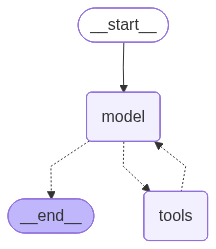

In [9]:
checkpointer = MemorySaver()

agent = create_agent(
    model=llm_gen,
    tools=tools,
    system_prompt=template,
    #checkpointer=checkpointer
)
agent

In [10]:
result = agent.invoke({'messages':[('user', '한국과 미국의 ICT 기관 협력 사례')]})
for message in result['messages']:
    print(message.content)
    print('--'*30)

한국과 미국의 ICT 기관 협력 사례
------------------------------------------------------------
Thought: 먼저 미국 ICT 관련 도구로 한국-미국 ICT 기관 협력 사례를 검색해 관련 자료를 찾겠습니다.
Action: functions.usa_ict
Action Input: {"query":"한국 미국 ICT 기관 협력 사례"}
------------------------------------------------------------
ICT 주요기업
6. 한국 협력 및 국내기업 진출사례
Ⅱ ICT 이슈Top 10
 16
(*) SUMMARY
① 미국 빅테크 기업, 인공지능 챗봇 개발에 주력
② 미국, 일본과 양자컴퓨팅 개발 협력
③ 미국, 우주 클라우드 컴퓨팅 시장 주도
④ 미국, 드론 배송 도입 활발
⑤ 미국, 긍정적인 의료 AI 인식 바탕으로 연구 활발
⑥ 미국, 반도체 산업 활성화에 박차
⑦ 미국, 기술 교류를 위한 국가 간 협력 활발
⑧ 미국, 사이버 보안 대응 강화
⑨ 미국, 6G 주도권 확보 위한 연구 추진
⑩ 미 국방부, 디지털 트윈 기술 도입 확대
※ 참고문헌

Ⅰ ICT 국가 산업 현황                   4
   (*) SUMMARY
   1. 국가 개황
   2.

ICT 주요기업
6. 한국 협력 및 국내기업 진출사례
Ⅱ ICT 이슈Top 10
 16
(*) SUMMARY
① 미국 빅테크 기업, 인공지능 챗봇 개발에 주력
② 미국, 일본과 양자컴퓨팅 개발 협력
③ 미국, 우주 클라우드 컴퓨팅 시장 주도
④ 미국, 드론 배송 도입 활발
⑤ 미국, 긍정적인 의료 AI 인식 바탕으로 연구 활발
⑥ 미국, 반도체 산업 활성화에 박차
⑦ 미국, 기술 교류를 위한 국가 간 협력 활발
⑧ 미국, 사이버 보안 대응 강화
⑨ 미국, 6G 주도권 확보 위한 연구 추진
⑩ 미 국방부, 디지털 트윈 기술 도입 확대
※ 참고문헌

Ⅰ ICT 국가 산업 현황                   4


In [11]:
result = agent.invoke({'messages':[('user', '미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.')]})
for message in result['messages']:
    print(message.content)
    print('--'*30)

미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.
------------------------------------------------------------

------------------------------------------------------------
ICT 주요기업
6. 한국 협력 및 국내기업 진출사례
Ⅱ ICT 이슈Top 10
 16
(*) SUMMARY
① 미국 빅테크 기업, 인공지능 챗봇 개발에 주력
② 미국, 일본과 양자컴퓨팅 개발 협력
③ 미국, 우주 클라우드 컴퓨팅 시장 주도
④ 미국, 드론 배송 도입 활발
⑤ 미국, 긍정적인 의료 AI 인식 바탕으로 연구 활발
⑥ 미국, 반도체 산업 활성화에 박차
⑦ 미국, 기술 교류를 위한 국가 간 협력 활발
⑧ 미국, 사이버 보안 대응 강화
⑨ 미국, 6G 주도권 확보 위한 연구 추진
⑩ 미 국방부, 디지털 트윈 기술 도입 확대
※ 참고문헌

Ⅰ ICT 국가 산업 현황                   4
   (*) SUMMARY
   1. 국가 개황
   2.

ICT 주요기업
6. 한국 협력 및 국내기업 진출사례
Ⅱ ICT 이슈Top 10
 16
(*) SUMMARY
① 미국 빅테크 기업, 인공지능 챗봇 개발에 주력
② 미국, 일본과 양자컴퓨팅 개발 협력
③ 미국, 우주 클라우드 컴퓨팅 시장 주도
④ 미국, 드론 배송 도입 활발
⑤ 미국, 긍정적인 의료 AI 인식 바탕으로 연구 활발
⑥ 미국, 반도체 산업 활성화에 박차
⑦ 미국, 기술 교류를 위한 국가 간 협력 활발
⑧ 미국, 사이버 보안 대응 강화
⑨ 미국, 6G 주도권 확보 위한 연구 추진
⑩ 미 국방부, 디지털 트윈 기술 도입 확대
※ 참고문헌

Ⅰ ICT 국가 산업 현황                   4
   (*) SUMMARY
   1. 국가 개황
   2.

ICT 주요법령 및 규제
  ② 반도체 과학법(CHIPS and Science Act)
 반도체·전자 기업, $1,660억 규모 투자 유치 
• 조 바이든

In [12]:
inputs = {'messages':[('user', '미국의 ICT 관련 정부 기구, 주요 법령, 국내 기업 진출 사례 각각 따로 검색해서 정보를 모아줘. 그리고 나서 일본의 AI 정책도 알려줘.')]}
for event in agent.stream(inputs, stream_mode='values'):
    message = event['messages'][-1]

    print(f'[{message.type}]: {message.content}')
    print('--'*30)

[human]: 미국의 ICT 관련 정부 기구, 주요 법령, 국내 기업 진출 사례 각각 따로 검색해서 정보를 모아줘. 그리고 나서 일본의 AI 정책도 알려줘.
------------------------------------------------------------
[ai]: Thought: 미국의 ICT 관련 정보(정부 기구, 주요 법령, 국내 기업(한국) 진출 사례)와 일본의 AI 정책 정보를 동시에 수집하기 위해 관련 검색들을 병렬로 실행하겠습니다.
Action: multi_tool_use.parallel
Action Input: {"tool_uses":[{"recipient_name":"functions.usa_ict","parameters":{"query":"미국 ICT 관련 정부 기구 목록 및 역할: FCC, NTIA, NIST, DHS, 상무부 등 주요 기관과 역할 요약"}},{"recipient_name":"functions.usa_ict","parameters":{"query":"미국 ICT 관련 주요 법령 및 규제 요약: Communications Act (1934), Telecommunications Act (1996), CALEA, CFAA, CLOUD Act, ECPA, PATRIOT Act, FCC 관련 규정 등"}},{"recipient_name":"functions.usa_ict","parameters":{"query":"한국 기업의 미국 ICT 시장 진출 사례: 삼성전자, LG전자, SK텔레콤/SK하이닉스, 네이버, 카카오 등의 미국 진출 사례 요약"}},{"recipient_name":"functions.japan_ict","parameters":{"query":"일본의 AI 정책: 최근 전략(2020-2025), 정부 기관, 규제·윤리 가이드라인, 산업 지원책 및 주요 발표 자료 요약"}}]}
------------------------------------------------------------
[tool]: ICT 정